In [8]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the 'c:\users\pc-1\documents\github\deep-learning\venv\scripts\python.exe -m pip install --upgrade pip' command.


# Deep Convolutional GANs or DCGANs

A GAN using convolutional layers in the generator and discriminator is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored in 2016 and has seen impressive results in generating new images.

I will use a series of convolutional or transpose convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get these convolutional networks to train.

# Face Generation

I will try to generate realistic fake faces, by defining and training a DCGAN. My main objective is to get a generator network to generate new images.

**Get Data** I'll be using the CelebFaces Attributes Dataset (CelebA) to train your adversarial networks.

**Pre processed Data** Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images.

Source - The data has been taken from udacity's deep learning github repository.

In [9]:
#Downloading the necessary files and the dataset
from IPython.display import clear_output

!wget -cq -O problem_unittests.py https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/project-face-generation/problem_unittests.py
!wget -cq -O processed_celeba_small.zip https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
clear_output()  
print("Downloaded Successfully")

Downloaded Successfully


In [10]:
# Extracting the dataset
!unzip -n processed_celeba_small.zip
clear_output()
print("Extracted Successfully")

Extracted Successfully


In [11]:
data_dir = 'processed_celeba_small/'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

#  Visualizing the data

The CelebA dataset contains over 200,000 celebrity images with annotations. These are color images with 3 color channels.This pre-processed dataset is a smaller subset of the very large CelebA data.

In [12]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

Function to create the DataLoader

In [13]:
def get_dataloader(batch_size, image_size, data_dir=
r"C:\\Users\\PC-1\\Documents\\GitHub\\deep-learning\\notebooks\\project-face-generation\\processed-celeba-small"):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    # define datasets using ImageFolder
    dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 4)

    return data_loader

In [14]:
# Define function hyperparameters
batch_size = 32
img_size = 32

# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

# Visualizing the pre processed data

We see a few images from the data set to know what are we dealing with.

C:\Users\PC-1\AppData\Local\Temp/ipykernel_34480/3060207770.py:13: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


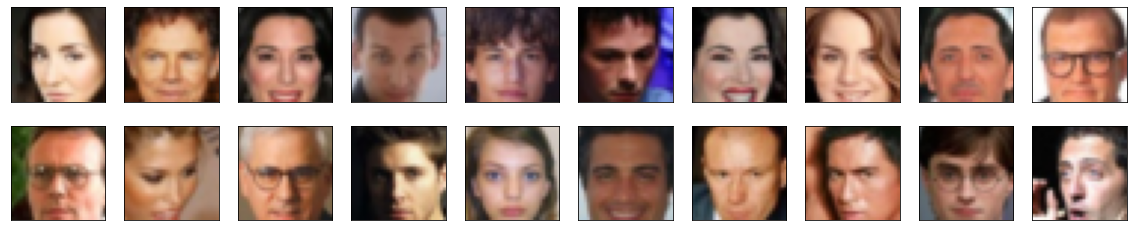

In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

# Scaling

Feature Scaling or Standardization: It is a step of Data Pre Processing which is applied to independent variables or features of data. It basically helps to normalise the data within a particular range.

The output of a tanh activated generator will contain pixel values in a range from -1 to 1,so we need to rescale our training images to range -1 to 1, which was 0 to 1 now.

In [16]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    min, max = feature_range
    x = x * (max - min) + min
    
    return x

In [17]:
# checking scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(1.)


# DEFINING MODEL

A GAN is comprised of two adversarial networks, a discriminator and a generator.

# Discriminator

The Discriminator. The discriminator in a GAN is simply a classifier. It tries to distinguish real data from the data created by the generator.

This is a convolutional classifier. I defined this with normalization.
The inputs to the discriminator are 32x32x3 tensor images
The output is a single value that will indicate whether a given image is real or fake.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
# helper conv function -> a convolutional layer + an optional batch norm layer
def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    #appending convolutional layer
    layers.append(conv_layer)
    
    #appending batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

# Discriminator Model

In [20]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        #leaky relu negative slope
        self.leaky_relu_slope = 0.2
        
        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        
       
        self.conv1 = conv(3, conv_dim, batch_norm=False)  
        self.conv2 = conv(conv_dim, conv_dim*2)           
        self.conv3 = conv(conv_dim*2, conv_dim*4)         
                
            
        # Classification layer -- final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
    
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        # relu applied to all conv layers but last
        out = F.leaky_relu(self.conv1(x), self.leaky_relu_slope)
        out = F.leaky_relu(self.conv2(out), self.leaky_relu_slope)
        out = F.leaky_relu(self.conv3(out), self.leaky_relu_slope)
        
        
        out = out.view(-1, self.conv_dim*4*4*4) #flattening
        
        # last, classification layer
        out = self.fc(out) 
        
        return out

# Generator

The generator part of a GAN learns to create fake data by incorporating feedback from the discriminator.

The generator should upsample an input and generate a new image of the same size as our training data 32x32x3. This should be mostly transpose convolutional layers with normalization applied to the outputs.

The inputs to the generator are vectors of some length z_size

The output is also an image of shape 32x32x3.

In [21]:
#deconv helper function, which creates a transpose convolutional layer + an optional batchnorm layer
def deconv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    
    # append transpose conv layer -- we are not using bias terms in conv layers
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


# Generator Model

In [22]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.deconv1 = deconv(conv_dim*4, conv_dim*2)
        self.deconv2 = deconv(conv_dim*2, conv_dim)
        self.deconv3 = deconv(conv_dim, 3, batch_norm=False)
        
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        ## fully-connected
        x = self.fc(x)
        
        #retrieve the batch size
        batch_size = x.shape[0]
        
        #reshape
        x = x.view(-1, self.conv_dim*4, 4, 4)
        
        
        # hidden transpose conv layers + relu
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
       
        
        # last layer + tanh activation
        x = self.deconv3(x)
        x = torch.tanh(x)
            
        return x

# Initializing The weights

To help your models converge, we should initialize the weights of the convolutional and linear layers in your model.



In [23]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
        
    # for every Linear layer and convolutional in a model..
    if classname.find('Linear') != -1 or classname.find('Convo2d') != -1:
        
        #Fills the input Tensor with values drawn from the normal distribution
        #mean =0 and standard deviation=0.02
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        
        #The bias terms or set to 0
        m.bias.data.fill_(0)

# Building The whole Network

Now, I call all the functions created and comlete the network.

In [24]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [25]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

# Training on GPU

In [26]:
import torch

# Check for a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


# DISCRIMINATOR AND GENERATOR LOSS
In a normal CNN, we have to deal with only one Loss data during training. Here, we have two, one for the discriminator and one for the generator.

# Discriminator Loss
For the discriminator, the total loss is the sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss.

# Generator Loss
The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to think its generated images are real.

In [27]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
   
    #retrieve the batch size
    batch_size = D_out.size(0)
    
    # smooth, real labels = 0.9
   
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)    # real labels = 1
    
    # move labels to GPU if available 
    if train_on_gpu:
        labels = labels.cuda()
        
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    
    return loss

def fake_loss(D_out):
    
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) # fake labels = 0
    
    if train_on_gpu:
        labels = labels.cuda()
    
    # The losses will by binary cross entropy loss with logits, which we can get with 
    # BCEWithLogitsLoss. This combines a sigmoid activation function and and binary 
    #cross entropy loss in one function.
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    
    return loss
    

# Optimiser

We'll use the Adam optimizer with the learning rate as 0.005.

In [28]:
import torch.optim as optim

lr = 0.005
beta1 = 0.3
beta2 = 0.999 # default value

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1, beta2))

# Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

We are training the discriminator by alternating on real and fake images.

Then the generator, which tries to trick the discriminator and should have an opposing loss function.

In [29]:
def train(D, G, n_epochs, print_every=2500):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            

            # ===============================================
            #               TRAIN THE NETWORKS
            # ===============================================
            
            d_optimizer.zero_grad()
            # ---------TRAIN THE DISCRIMINATOR ----------------
            
            # Train the discriminator on real and fake images
            
            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
                
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            
            # Train with fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)  #generate fake images from generator
            
            
            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
             # add up loss and perform backprop
            # For the discriminator, the total loss is the sum of the losses for 
            # real and fake images, d_loss = d_real_loss + d_fake_loss.
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            # ---------TRAIN THE GENERATOR ----------------
             
            # Train the generator with an adversarial loss     
             
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            
            fake_images = G(z)
            
             # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images) # pass the fake images to the discriminator as input
            
            g_loss = real_loss(D_fake) # use real loss to flip labels
            
            # perform backprop and optimization steps
            g_loss.backward()
            g_optimizer.step()
            
            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
                
        
        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode
        
     # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses


            


In [30]:
# set number of epochs 
n_epochs = 25

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   25] | d_loss: 1.4882 | g_loss: 9.3699
Epoch [    2/   25] | d_loss: 1.5430 | g_loss: 1.1817
Epoch [    3/   25] | d_loss: 1.3782 | g_loss: 1.1480
Epoch [    4/   25] | d_loss: 1.3194 | g_loss: 0.8422
Epoch [    5/   25] | d_loss: 1.1039 | g_loss: 1.1009
Epoch [    6/   25] | d_loss: 1.6123 | g_loss: 0.6519
Epoch [    7/   25] | d_loss: 1.4483 | g_loss: 0.7834
Epoch [    8/   25] | d_loss: 1.3609 | g_loss: 2.3874
Epoch [    9/   25] | d_loss: 0.8579 | g_loss: 1.7338
Epoch [   10/   25] | d_loss: 1.3812 | g_loss: 2.5626
Epoch [   11/   25] | d_loss: 0.7147 | g_loss: 2.6127
Epoch [   12/   25] | d_loss: 0.7599 | g_loss: 1.3149
Epoch [   13/   25] | d_loss: 0.7969 | g_loss: 2.7954
Epoch [   14/   25] | d_loss: 1.0144 | g_loss: 3.2741
Epoch [   15/   25] | d_loss: 1.5223 | g_loss: 4.6766
Epoch [   16/   25] | d_loss: 0.9685 | g_loss: 1.3446
Epoch [   17/   25] | d_loss: 0.4539 | g_loss: 3.2560
Epoch [   18/   25] | d_loss: 1.1143 | g_loss: 4.6525
Epoch [   19/   25] | d_loss

# Training Loss

Plotting the training losses for the generator and discriminator, recorded after each epoch.

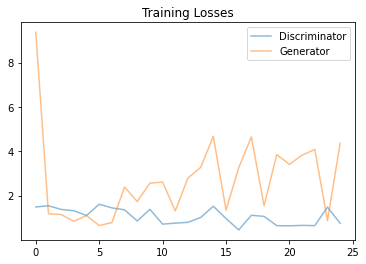

In [31]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Generator samples from training

Now we see the faces we wanted to see that doesn't even exist in this world and are 100% fake created by the machine.

In [32]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [33]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

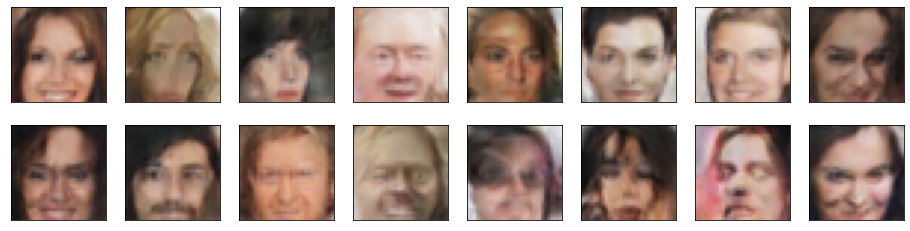

In [34]:
_ = view_samples(-1, samples)

In [35]:
# Project name used for jovian.commit
project_name = 'course-project-pk'

import jovian

jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY:API KEY:API KEY:API KEY:API KEY:

[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY:API KEY:API KEY:API KEY:

ApiError: The API key provided is invalid or expired.